In [1]:

import os 
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import ta
import talib
from statsmodels.tsa.stattools import adfuller

from Strat_4.technical_analysis import *
from ALGO_KT1 import Preprocessing_functions as pf


ticker = "BTC-USD"
df = pf.downlaod_symbol_data(ticker, period = "24mo")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,high_low,low_close,high_close,gap
Date,,,,,,,,,,,,,,
2022-05-09 00:00:00+00:00,34060.02,34222.07,30296.95,30296.95,63355494961,0.0,0.0,11.048349,11.048349,-0.475778,11.469558,0.000000,-11.469558,NaN
2022-05-10 00:00:00+00:00,30273.65,32596.31,29944.80,31022.91,59811038817,0.0,0.0,1.086258,-2.474958,-7.672217,8.134387,-3.600325,-4.826927,-0.076905
2022-05-11 00:00:00+00:00,31016.18,32013.40,28170.41,28936.36,70388855818,0.0,0.0,9.175114,6.705597,-3.215161,12.004317,-2.718988,-9.611725,-0.021694
2022-05-12 00:00:00+00:00,28936.73,30032.44,26350.49,29047.75,66989173272,0.0,0.0,8.937568,-0.383665,-3.786572,12.259910,-10.236090,-3.278755,0.001279
2022-05-13 00:00:00+00:00,29030.91,30924.80,28782.33,29283.10,42841124537,0.0,0.0,0.856260,-0.868695,-6.523702,6.928000,-1.739852,-5.308684,-0.057974


In [2]:

#df = ROC(df)

df = EMA(df)

df = momentum_oscillators(df) ## now vwap 

df = volatility(df)

df = reversal_patterns(df)

df = continuation_patterns(df)

df = magic_doji(df)

df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                     df['Low'],
                                                     df['Close'],
                                                     df['Volume'])



df['vwap_diff'] = df['vwap'] - df['Close'] # if +ve then VWAP > Close
df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

df = df.dropna()

In [16]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'open_low', 'open_close', 'open_high', 'high_low', 'low_close',
       'high_close', 'gap', 'EMA8', 'EMA20', 'EMA50', 'EMA100', 'EMA200',
       'rsi', 'macd_values', 'macd_signal_line', 'atr', 'bband_up',
       'bband_mid', 'bband_low', 'hammer', 'hanging_man', 'engulfing_pattern',
       'dark_cloud', 'piercing_line', 'morning_star', 'evening_star',
       'shooting_star', 'inverted_hammer', 'harami', 'harami_cross',
       'belt_hold', 'upsidegap_two_crows', 'three_black_crows',
       'three_white_soldiers', 'advance_block', 'stalled_pattern',
       'counterattack', 'tasuki', 'rf_three_methods', 'separating_lines',
       'long_legged_doji', 'gravestone_doji', 'dragonfly_doji', 'tristar_doji',
       'vwap', 'vwap_diff', 'vwap_pct_diff', 'buy_vwap', 'sell_vwap',
       'vwap_strat'],
      dtype='object')

In [3]:
stats = pf.dist_stats(df, "vwap_diff")
stats_pct = pf.dist_stats(df, "vwap_pct_diff")
stats_pct

,vwap_pct_diff
count,532.0000
min,-0.1563
max,0.1169
mean,-0.0125
median,-0.0093
std,0.0461
skew,-0.3159
kurtosis,0.2942


In [10]:
vwap_band_low = 0.1 * (-1)
vwap_band_high = 0.08

profit_low = 0.07 * (-1)
profit_high = 0.06


df['buy_vwap'] = df['vwap_pct_diff'] < vwap_band_low
df['sell_vwap'] = df['vwap_pct_diff'] > vwap_band_high 
df['vwap_strat'] = 0

df['vwap_strat'] = np.where(df["buy_vwap"] == True, 1, df['vwap_strat'])
df['vwap_strat'] = np.where(df["sell_vwap"] == True, -1, df['vwap_strat'])

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,...,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,vwap,vwap_diff,vwap_pct_diff,buy_vwap,sell_vwap,vwap_strat
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-24 00:00:00+00:00,16611.64,16771.47,16501.77,16604.46,26129037414,0.0,0.0,0.661404,0.043223,-0.962157,...,100,0,0,0,16588.050449,-16.409551,-0.000993,False,False,0
2022-11-25 00:00:00+00:00,16602.27,16603.32,16388.40,16521.84,18678255976,0.0,0.0,1.288197,0.484452,-0.006324,...,0,0,0,0,16518.592208,-3.247792,-0.000197,False,False,0
2022-11-26 00:00:00+00:00,16521.58,16666.86,16416.23,16464.28,18000008764,0.0,0.0,0.637651,0.346819,-0.879335,...,0,0,0,0,16494.849600,30.569600,0.001859,False,False,0
2022-11-27 00:00:00+00:00,16463.88,16594.41,16437.03,16444.63,20443898509,0.0,0.0,0.163084,0.116923,-0.792826,...,100,100,0,0,16492.183782,47.553782,0.002932,False,False,0
2022-11-28 00:00:00+00:00,16440.22,16482.93,16054.53,16217.32,27743025156,0.0,0.0,2.346015,1.355821,-0.259790,...,0,0,0,0,16468.904897,251.584897,0.015299,False,False,0


In [11]:
print(df['vwap_strat'].value_counts())

vwap_strat
 0    496
 1     25
-1     11
Name: count, dtype: int64


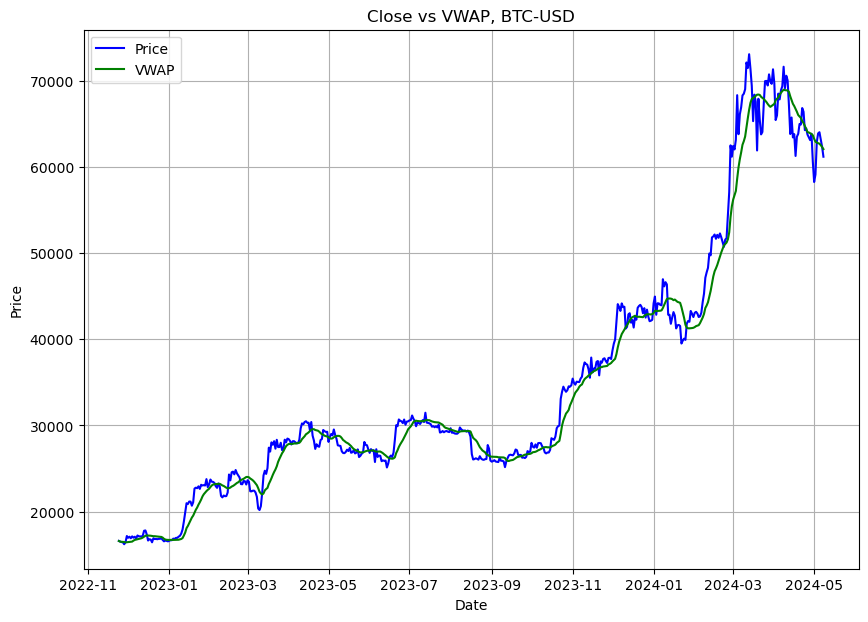

In [15]:
# Create the plot
plt.figure(figsize=(10, 7))  # Set the figure size
plt.plot(df.index, df['Close'], label="Price", color = "blue")
plt.plot(df.index, df['vwap'], label="VWAP", color = 'green')
# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Close vs VWAP, {ticker}")
# Add legend
plt.legend()
# Show the plot
plt.grid(True)
plt.show()